# Pooled model for NBA players points per games prediction

Amos Colombo, Christian Pala

## Libraries

In [14]:
%matplotlib inline
import numpy as np
import pymc3 as pm
import pandas as pd
import arviz as az
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.stats import halfnorm
sns.set(rc={'figure.figsize':(12,8)})
sns.set_theme()
az.style.use('arviz-darkgrid')
np.random.seed(44)

## Preprocessing

We read the data from a pickle, to preserve the arrays

In [102]:
# Data
training = pd.read_pickle(Path('..','data', 'train.pkl'))
testing = pd.read_pickle(Path('..','data', 'test.pkl'))

# Save the player for novel predictions
novel_player_features = training.tail(1).x_train_1.values[0]

# remove the last row with the problematic player
training = training.drop(training.index[[-1]])
testing = testing.drop(testing.index[[-1]])

# Features and labels:
# Note: the data has already been centered during preprocessing.
x_train = np.concatenate(np.concatenate(training.iloc[:, 2:42].values)).reshape(200, 40)
y_train = np.concatenate(training.iloc[:, 42:82].values).astype(np.float64)

x_test = np.concatenate(testing.x_test_1.values).reshape(200, 1)
y_test = testing.y_test_1.values.astype(np.float64)

## Modelling

Pooled Linear Regression

Treat all five players the same by fitting a single model:

$$y_i = \alpha + \beta_j x_i + \epsilon_i$$

where:

$y_i$: the player's observed score for game i.

$\alpha$ : intercept. We standardized the data, so it represents the mean points per game in the NBA.

$x_i$: the standardized points scored for game i.

$\beta_j$ : the regression coefficients for the j-th feature of the model.

$\epsilon_i$ random variation of the measures

In this model, we sample 40 different $\beta_j$ values.

### Priors and likelihoods

We used weakly informative priors, based on the data we collected.

In [12]:
mu_y = y_train.mean()
s_y = y_train.std()
s_x = np.mean(np.std(np.array(x_train)))

print(f"Mean points scored: {mu_y:.3f}")
print(f"Standard deviation in points scored: {s_y:.3f}")
print(f"Standard deviation in points scored for each list of the 40 previous matches: {s_x:.3f}")

Mean points scored: 25.495
Standard deviation in points scored: 10.765
Standard deviation in points scored for each list of the 40 previous matches: 9.998


And assumed alpha and beta are normally distributed, i.e. we assume the value of the intercept is centered around the mean of the dataset, and we do not assume there is a direction in the relationship between the previous points and the future points, this allows the model to learn from the data, instead of assuming momentum exisits, for instance.

In [132]:
# model
with pm.Model() as pooled_model_mlr:
    # priors:
    alpha = pm.Normal('alpha', mu=mu_y, sigma=s_y)
    beta = pm.Normal('beta', mu=0, sigma=s_x, shape=40)
    sigma = pm.HalfNormal('sigma', sigma=s_y)

    # likelihood:
    mu = alpha + pm.math.dot(x_train, beta)

    # observed data, since we were missing some density in the predictive checks, we used a more robust
    # distribution with the student t.
    y_pred = pm.StudentT ('y_pred', nu=4, mu=mu, sd=sigma, observed= y_train)

    # inference:
    trace = pm.sample(1000, tune=1000, cores=2, chains=2)

C:\Users\light\OneDrive\Documents\Study\SUPSI\Year 3\bayesian_data_analysis_and_probabilistic_programming\coding\venv\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\light\OneDrive\Documents\Study\SUPSI\Year 3\bayesian_data_analysis_and_probabilistic_programming\coding\venv\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\light\OneDrive\Documents\Study\SUPSI\Year 3\bayesian_data_analysis_and_probabilistic_programming\coding\venv\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufu

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 690 seconds.


## Convergence check

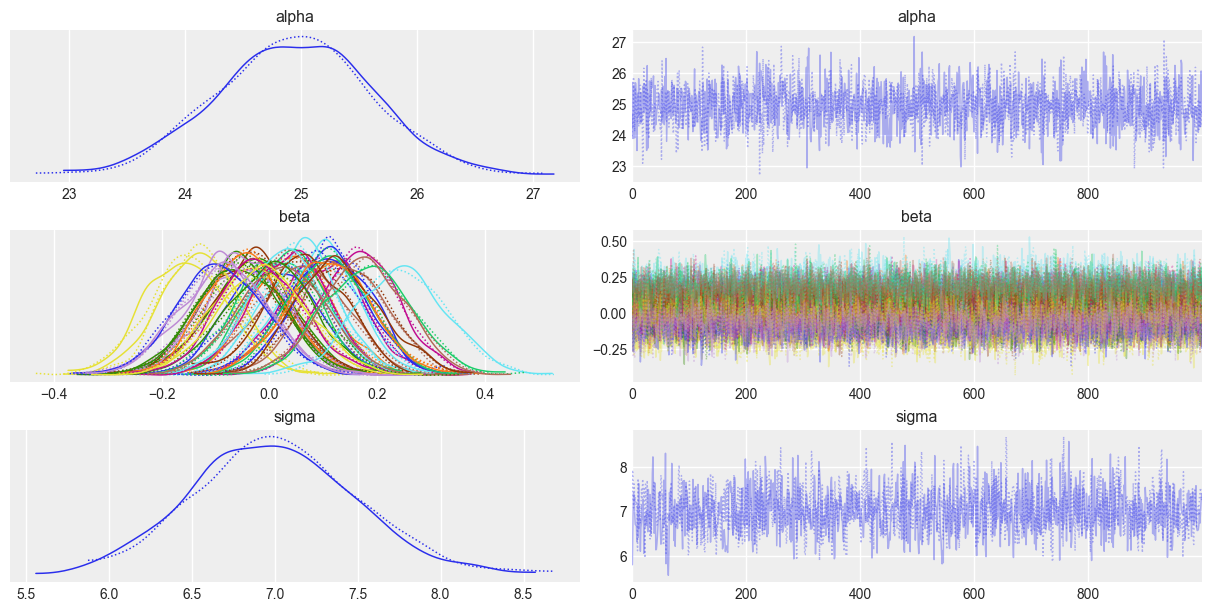

In [133]:
with pooled_model_mlr:
    az.plot_trace(trace);

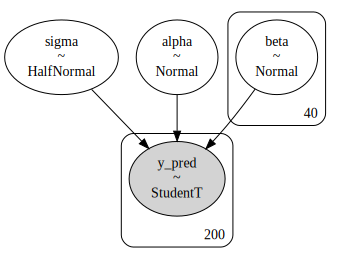

In [134]:
pm.model_to_graphviz(pooled_model_mlr)

In [135]:
with pooled_model_mlr:
    display(az.summary(trace))

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha     24.934  0.662  23.725   26.202      0.014    0.010    2125.0   
beta[0]    0.011  0.081  -0.128    0.168      0.002    0.002    1742.0   
beta[1]    0.110  0.081  -0.033    0.268      0.002    0.001    1880.0   
beta[2]   -0.037  0.081  -0.190    0.113      0.002    0.002    1682.0   
beta[3]    0.098  0.076  -0.058    0.225      0.002    0.001    1657.0   
beta[4]   -0.049  0.083  -0.205    0.104      0.002    0.002    1920.0   
beta[5]    0.090  0.076  -0.049    0.226      0.002    0.001    2334.0   
beta[6]   -0.152  0.077  -0.300   -0.015      0.002    0.001    1830.0   
beta[7]    0.013  0.076  -0.142    0.145      0.002    0.001    2107.0   
beta[8]   -0.046  0.082  -0.205    0.095      0.002    0.002    1821.0   
beta[9]    0.059  0.084  -0.098    0.213      0.002    0.002    1948.0   
beta[10]   0.118  0.071  -0.026    0.236      0.002    0.001    2227.0   
beta[11]   0.041  0.075  -0.094    0.188      0.002    0.001    1564.0   
beta[12]  -0.055  0.076  -0.188    0.093      0.002    0.002    1609.0   
beta[13]   0.168  0.073   0.045    0.318      0.002    0.001    2225.0   
beta[14]  -0.036  0.075  -0.182    0.101      0.002    0.002    1906.0   
beta[15]   0.057  0.070  -0.078    0.183      0.002    0.001    2120.0   
beta[16]  -0.128  0.072  -0.260    0.013      0.002    0.001    1810.0   
beta[17]   0.031  0.076  -0.106    0.172      0.002    0.002    2045.0   
beta[18]  -0.044  0.075  -0.185    0.089      0.002    0.001    2133.0   
beta[19]   0.138  0.075   0.014    0.293      0.002    0.001    2465.0   
beta[20]   0.098  0.077  -0.045    0.245      0.002    0.001    1859.0   
beta[21]  -0.044  0.075  -0.183    0.100      0.002    0.001    1978.0   
beta[22]  -0.055  0.078  -0.198    0.089      0.002    0.001    2178.0   
beta[23]   0.036  0.071  -0.087    0.178      0.002    0.001    1895.0   
beta[24]   0.067  0.073  -0.059    0.209      0.002    0.001    2218.0   
beta[25]   0.034  0.075  -0.103    0.183      0.002    0.002    2172.0   
beta[26]  -0.023  0.080  -0.171    0.124      0.002    0.002    1974.0   
beta[27]   0.111  0.075  -0.028    0.251      0.002    0.001    2305.0   
beta[28]  -0.084  0.083  -0.237    0.070      0.002    0.002    1667.0   
beta[29]   0.024  0.079  -0.128    0.166      0.002    0.002    2264.0   
beta[30]  -0.092  0.080  -0.248    0.046      0.002    0.001    2201.0   
beta[31]   0.109  0.079  -0.055    0.247      0.002    0.001    1810.0   
beta[32]   0.003  0.084  -0.156    0.151      0.002    0.002    1982.0   
beta[33]  -0.018  0.081  -0.160    0.147      0.002    0.002    1709.0   
beta[34]   0.135  0.079   0.001    0.294      0.002    0.001    1739.0   
beta[35]   0.244  0.084   0.100    0.411      0.002    0.001    1753.0   
beta[36]  -0.012  0.085  -0.179    0.141      0.002    0.002    1868.0   
beta[37]   0.182  0.082   0.038    0.339      0.002    0.001    1684.0   
beta[38]  -0.085  0.083  -0.234    0.074      0.002    0.001    1988.0   
beta[39]   0.175  0.078   0.036    0.330      0.002    0.001    1798.0   
sigma      7.006  0.490   6.124    7.954      0.012    0.009    1539.0   

          ess_tail  r_hat  
alpha       1558.0   1.00  
beta[0]     1393.0   1.00  
beta[1]     1480.0   1.00  
beta[2]     1359.0   1.00  
beta[3]     1475.0   1.00  
beta[4]     1480.0   1.00  
beta[5]     1588.0   1.00  
beta[6]     1580.0   1.00  
beta[7]     1663.0   1.00  
beta[8]     1531.0   1.00  
beta[9]     1555.0   1.00  
beta[10]    1580.0   1.00  
beta[11]    1392.0   1.00  
beta[12]    1390.0   1.00  
beta[13]    1629.0   1.00  
beta[14]    1254.0   1.00  
beta[15]    1325.0   1.00  
beta[16]    1502.0   1.00  
beta[17]    1419.0   1.00  
beta[18]    1512.0   1.01  
beta[19]    1539.0   1.00  
beta[20]    1436.0   1.00  
beta[21]    1556.0   1.00  
beta[22]    1609.0   1.00  
beta[23]    1494.0   1.00  
beta[24]    1541.0   1.00  
beta[25]    1415.0   1.00  
beta[26]    1568.0   1.00  
beta[27]    1553.

C:\Users\light\OneDrive\Documents\Study\SUPSI\Year 3\bayesian_data_analysis_and_probabilistic_programming\coding\venv\lib\site-packages\arviz\plots\plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (42) in plot_posterior, generating only 40 plots
  warnings.warn(


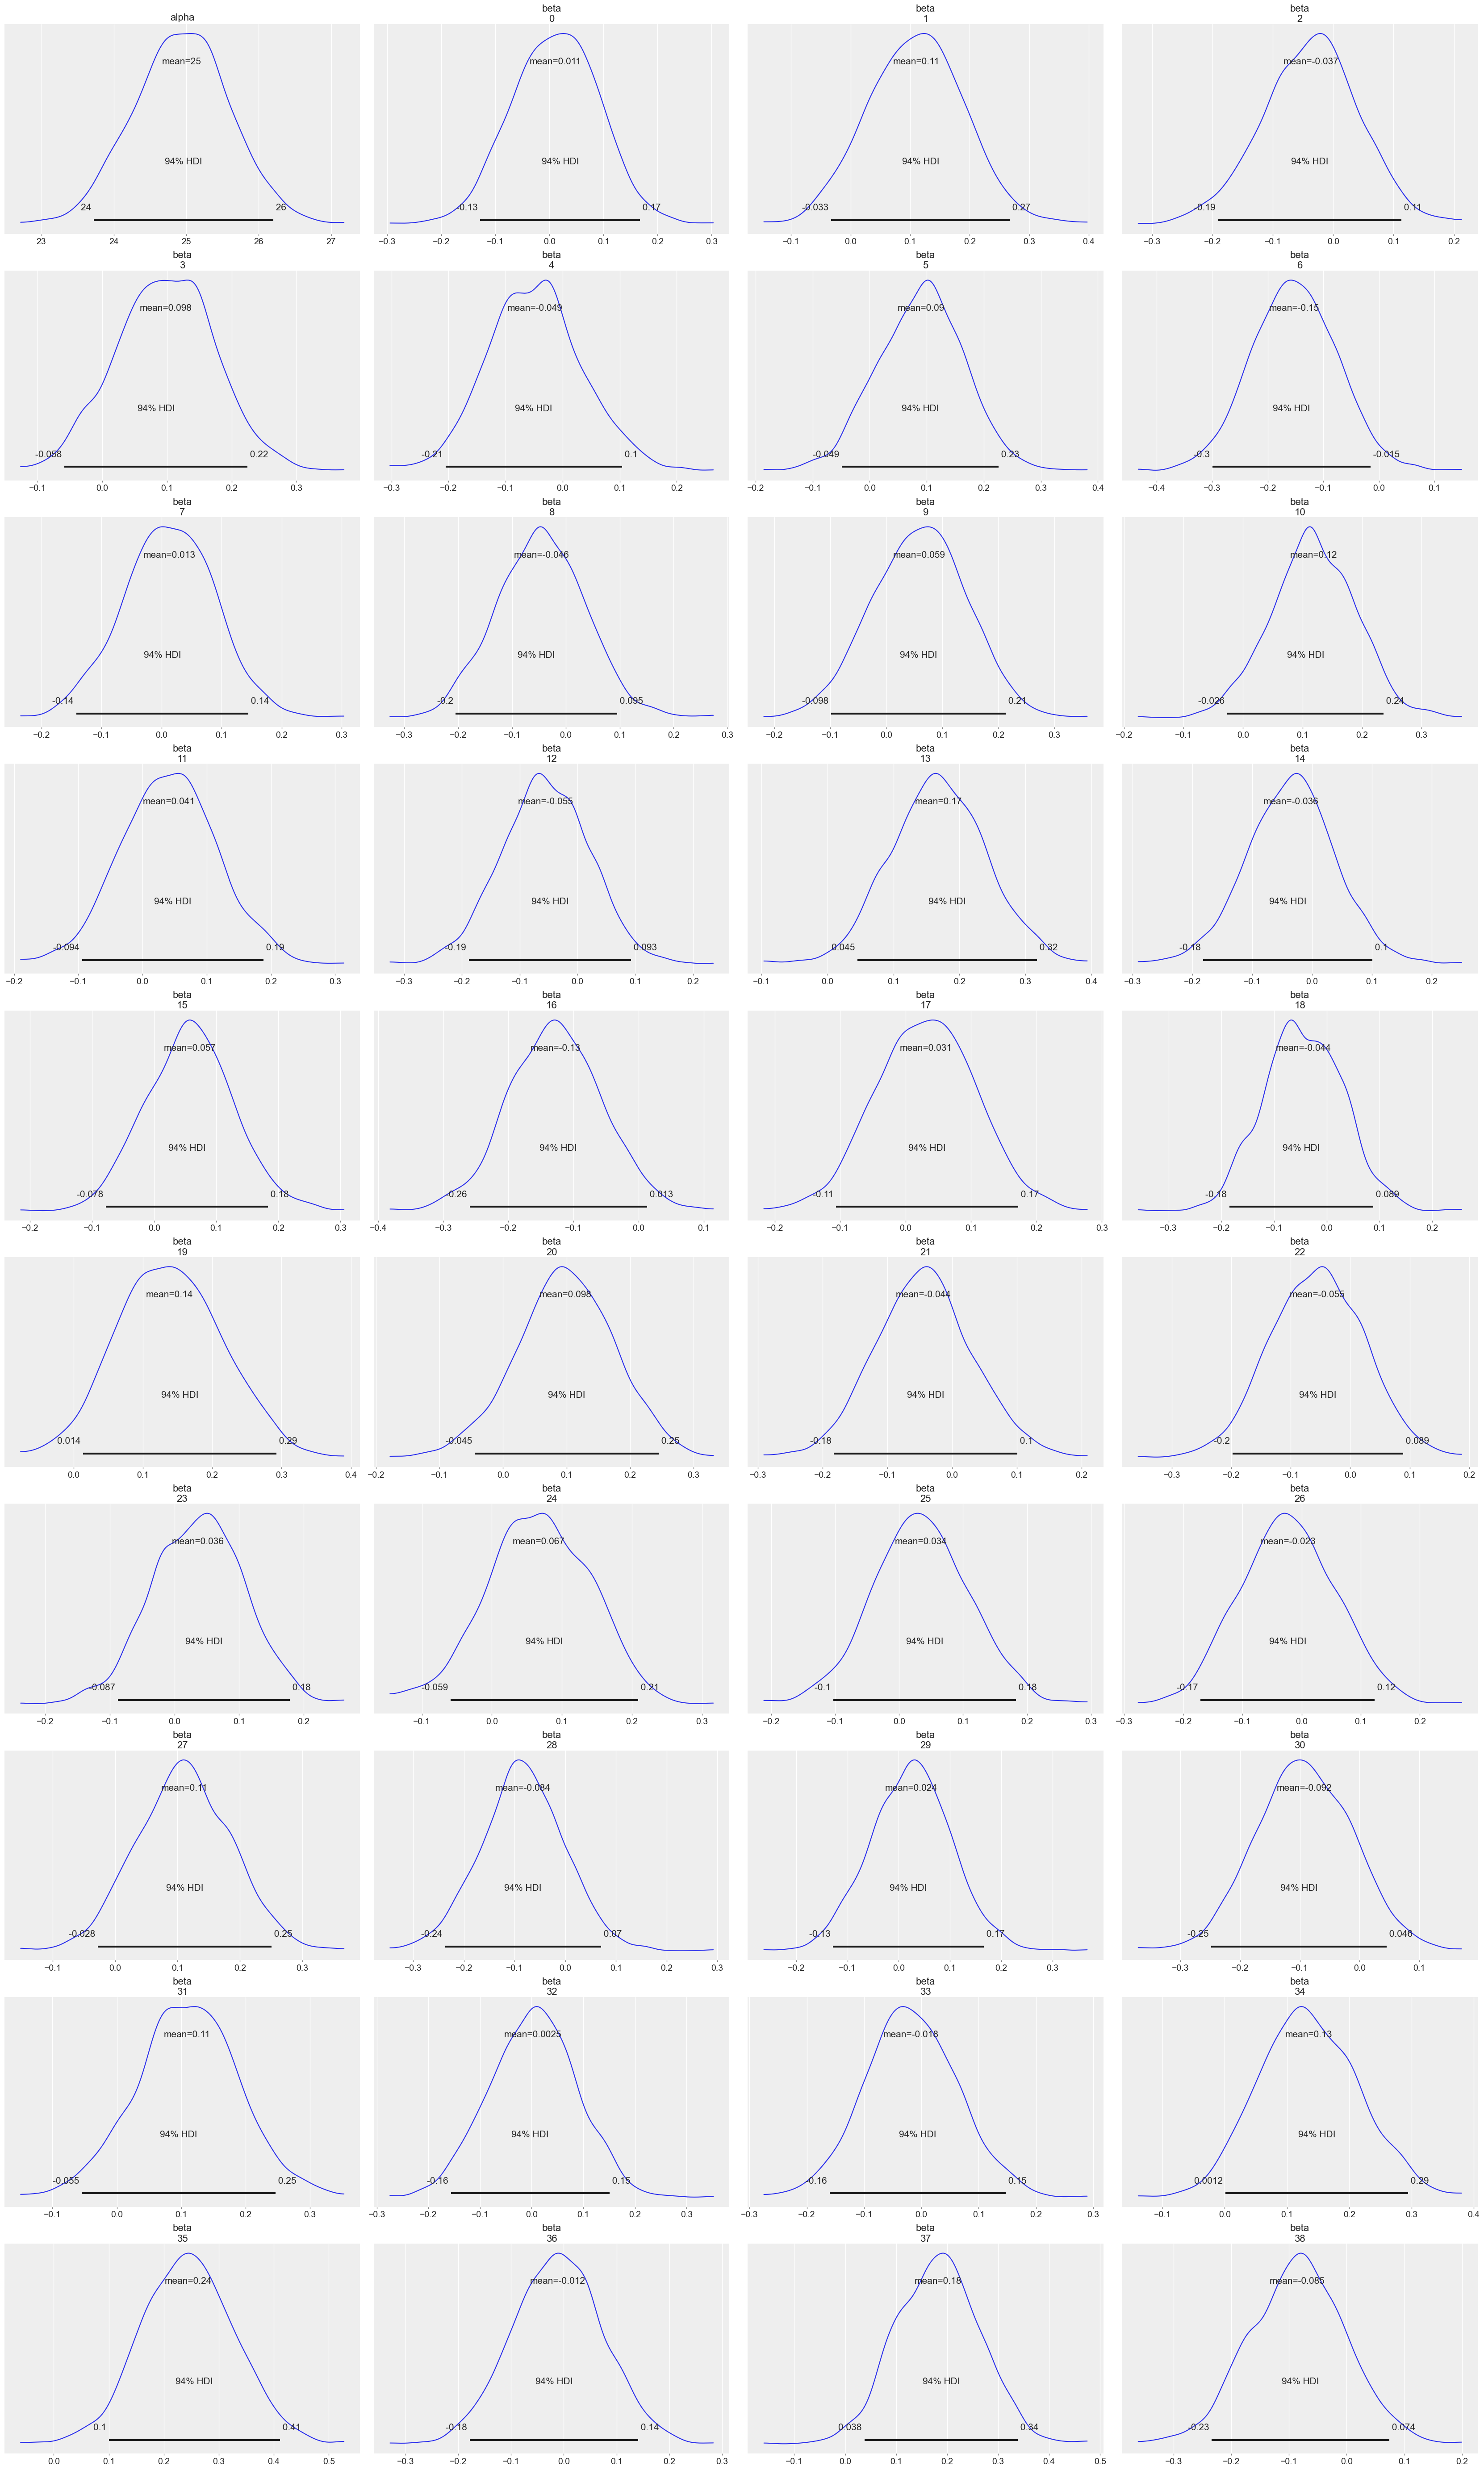

In [138]:
plt.rcParams.max_subplots = 50
with pooled_model_mlr:
    az.plot_posterior(trace);

C:\Users\light\OneDrive\Documents\Study\SUPSI\Year 3\bayesian_data_analysis_and_probabilistic_programming\coding\venv\lib\site-packages\pymc3\sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


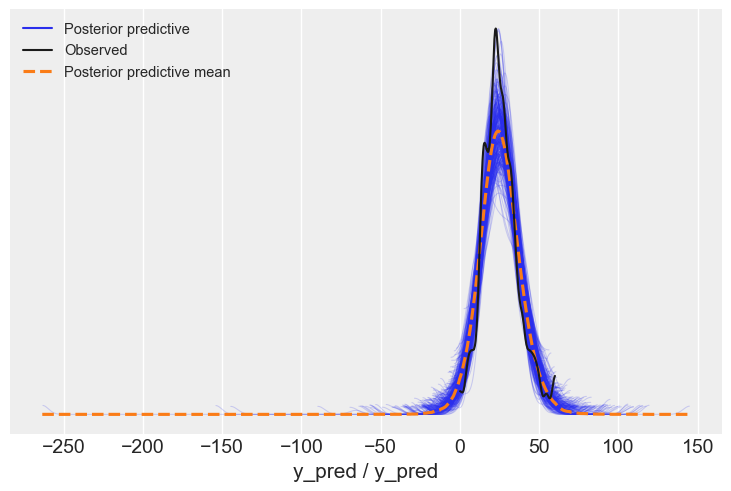

In [137]:
with pooled_model_mlr:
     ppc = pm.sample_posterior_predictive(trace, samples=300)
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=pooled_model_mlr));

## Posterior mean for a player in the training set:

In [224]:
x_lebron = np.array(x_train)[0, :, :]

In [225]:
alpha_samples = trace['alpha']
beta_samples = trace['beta']
mu_player = alpha_samples + np.dot(x_lebron, beta_samples.T)

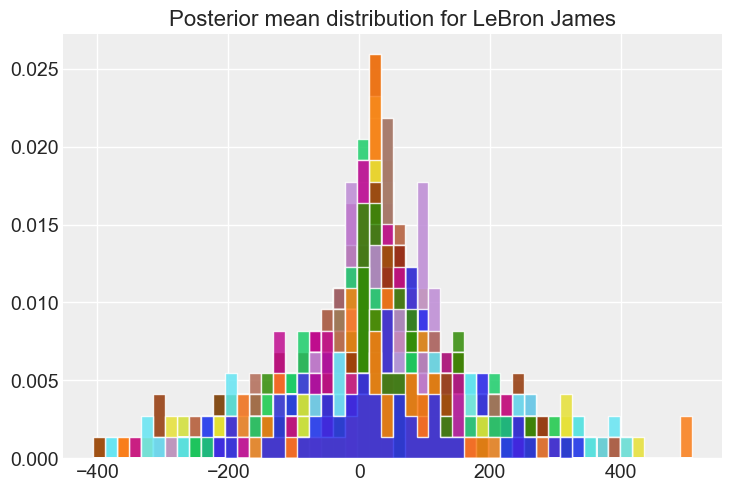

LeBron James predicted mean: 27.932
LeBron James predicted mean standard deviation: 76.735


In [226]:
# plot the posterior predictive distribution
plt.hist(mu_player, bins=50, density=True,histtype='stepfilled', alpha=0.85)
plt.title('Posterior mean distribution for LeBron James')
plt.savefig(Path('..', 'data', 'figures', 'LeBron James_posterior_predictive_pooled.png'))
plt.show()

# print the mean and standard deviation of the posterior predictive distribution
print(f'LeBron James predicted mean: {mu_player.mean():.3f}')
print(f'LeBron James predicted mean standard deviation: {mu_player.std():.3f}')

## Predictive Distribution for a player in the training set:

In [218]:
x_lebron_test = x_test[0].ravel()

In [219]:
predictive_distribution = []

alpha_samples = trace['alpha']
beta_samples = trace['beta']
sigma_samples = trace['sigma']

for i in range(len(alpha_samples)):
    mu_player = alpha_samples[i] + np.dot(x_lebron_test, beta_samples[i]) # compute the mean for the predictive distribution
    y_pred = np.random.normal(mu_player, sigma_samples[i]) # sample from the predictive distribution

    y_pred = np.random.normal(loc=mu_player, scale=sigma_samples[i])
    # y_pred_chi = np.random.chisquare(df=4)
    # y_pred = y_pred / np.sqrt(y_pred_chi/4)
    predictive_distribution.append(y_pred)

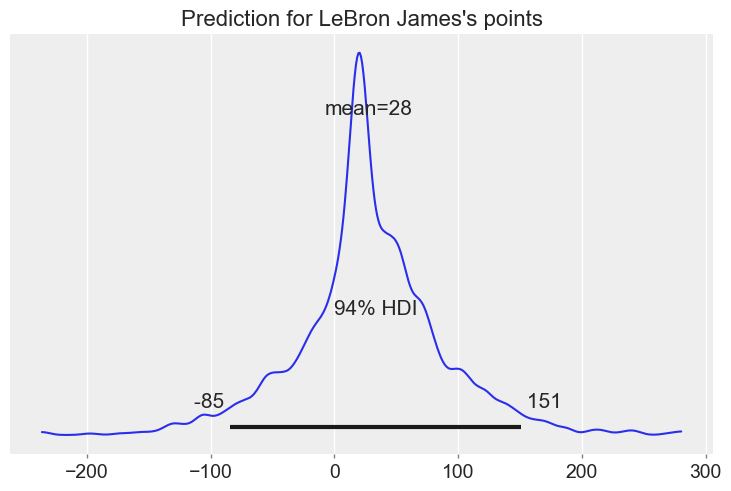

In [220]:
az.plot_posterior(np.array(predictive_distribution))
plt.title("Prediction for LeBron James's points");

In [221]:
# print the mean and standard deviation of the posterior predictive distribution
print(f'LeBron James predicted mean: {np.array(predictive_distribution).mean():.3f}')
print(f'LeBron James predicted mean standard deviation: {np.array(predictive_distribution).std():.3f}')

LeBron James predicted mean: 27.758
LeBron James predicted mean standard deviation: 59.106


## Posterior prediction for a novel player:

We selected Wayne Ellington as the novel player:

In [227]:
x_new = novel_player_features

In [145]:
with pm.Model() as model_pooled_with_pred:

    alpha = pm.Normal('alpha', mu=mu_y, sigma=s_y)
    beta = pm.Normal('beta', mu=0, sigma=s_x, shape=40)
    sigma = pm.HalfNormal('sigma', sigma=s_y)

    # likelihood:
    mu = alpha + pm.math.dot(x_train, beta)

    # observed data:
    y_pred = pm.StudentT ('y_pred', nu=4, mu=mu, sd=sigma, observed= y_train)

    # Novel player
    x_novel = pm.Data("x_novel", x_new)
    mu_novel = alpha + pm.math.dot(x_novel, beta)
    y_novel = pm.Normal("y_novel", mu=mu_novel, sigma=sigma)

In [146]:
with model_pooled_with_pred:
    # inference:
    trace_novel = pm.sample(1000, tune=1000, cores=2, chains=2)

C:\Users\light\OneDrive\Documents\Study\SUPSI\Year 3\bayesian_data_analysis_and_probabilistic_programming\coding\venv\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\light\OneDrive\Documents\Study\SUPSI\Year 3\bayesian_data_analysis_and_probabilistic_programming\coding\venv\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\light\OneDrive\Documents\Study\SUPSI\Year 3\bayesian_data_analysis_and_probabilistic_programming\coding\venv\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufu

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 822 seconds.


In [228]:
with model_pooled_with_pred:
    display(az.summary(trace_novel, var_names=['y_novel']))

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
y_novel  5.939  8.195   -9.26   20.946      0.165    0.158    2481.0   

         ess_tail  r_hat  
y_novel    1557.0    1.0

For Wayne Ellington the pooled model predicts ~ 6 points on average, with a lot of variation, which seems reasonable to us.